In [1]:
import sys
from os import getcwd
from os.path import join
import pandas as pd
sys.path.insert(0, join(getcwd(), "../module_code"))

from data.load import load_data, load_outcomes
from cli_utils import load_cli_args, init_cli_args

sys.argv = [sys.argv[0]]
load_cli_args("../options.yml")
args = init_cli_args()

/home/davina/mambaforge/envs/crrt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Outcomes

In [2]:
outcomes = load_outcomes(args.ucla_crrt_data_dir, ["IP_PATIENT_ID", "Start Date"])

mealy | INFO - *****Loading Outcomes...*****


In [3]:
outcomes.columns

Index(['Month', 'Hospital name', 'CRRT Total Days', 'End Date', 'Machine',
       'ICU', 'Recov. renal funct.', 'Transitioned to HD', 'Comfort Care',
       'Expired ', 'Unnamed: 11', 'recommend_crrt', 'CRRT Year',
       'Num Prev CRRT Treatments'],
      dtype='object')

In [4]:
granular_outcome = outcomes[["Recov. renal funct.", "Transitioned to HD", "Comfort Care", "Expired "]].idxmax(axis=1)
binary_outcome = outcomes["recommend_crrt"]

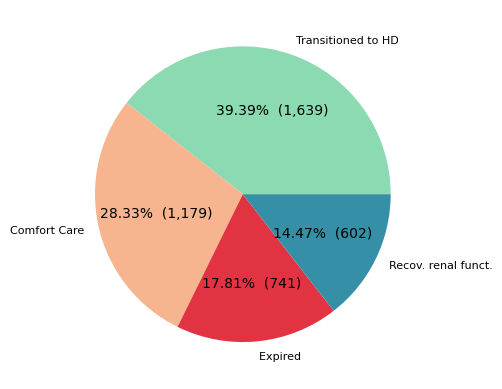

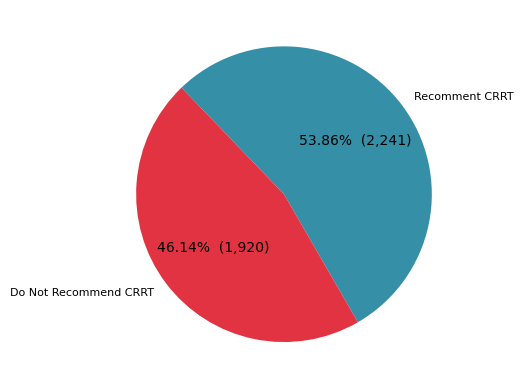

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
counts = granular_outcome.value_counts()
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html
plt.pie(
    counts,
    # autopct="%1.1f%%",
    labels=counts.index,
    autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(counts)/100),
    # https://seaborn.pydata.org/tutorial/color_palettes.html
    colors=[
        sns.color_palette("mako")[-1],
        sns.color_palette("rocket")[-1],
        sns.color_palette("rocket")[-3],
        sns.color_palette("mako")[-3],
    ]
)
plt.show()

counts = binary_outcome.value_counts()
# plt.pie(counts,  
plt.pie(
    counts,
    # autopct="%1.1f%%",
    autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(counts)/100),
    labels=["Recomment CRRT", "Do Not Recommend CRRT", ],
    colors=[
            sns.color_palette("mako")[-3],
            sns.color_palette("rocket")[-3],
    ],
    startangle=300
)
plt.show()

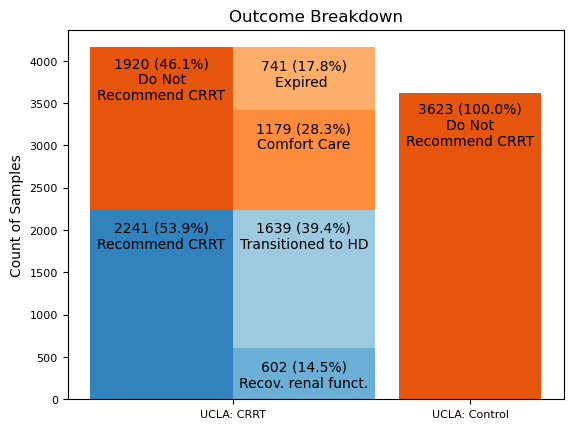

<Figure size 640x480 with 0 Axes>

In [31]:
import numpy as np
# Ref: https://stackoverflow.com/a/68107816/1888794
fig, ax = plt.subplots()
bin_names = ["Recommend CRRT", "Do Not\nRecommend CRRT"]
granular_names = ['Recov. renal funct.', 'Transitioned to HD', 'Comfort Care', 'Expired ']
counts = granular_outcome.value_counts()[granular_names]
bin_counts = binary_outcome.value_counts()

cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

width=0.6
ax.bar(["UCLA: CRRT"], bin_counts[1], width=-width, label=bin_names[0], align="edge", color=outer_colors[0])  # the names are reverse
ax.bar(["UCLA: CRRT"], bin_counts[0], width=-width, bottom=bin_counts[1], label=bin_names[1], align="edge", color=outer_colors[1])

bottom = 0
for i in range(len(counts)):
    if i>0:
        bottom += counts[i-1]
    ax.bar(["UCLA: CRRT"], counts[i], width=width, bottom=bottom, label=granular_names[i], align="edge", color=inner_colors[i])  # the names are reverse


ax.bar(["UCLA: Control"], 3623, width=width, label="Do Not\nRecommend CRRT", color=outer_colors[1])  # the names are reverse

# this is hacky af but whatever
i = 0
for bars in ax.containers:
    padding = -40 if bars.get_label() == "Do Not\nRecommend CRRT" else -30
    total = sum(bin_counts) if i <= 5 else 3623
    ax.bar_label(bars, padding=padding, labels=[f'{x} ({x/total:.1%})\n{bars.get_label()}' for x in bars.datavalues])
    i += 1    

ax.set_ylabel("Count of Samples")
ax.set_title("Outcome Breakdown")

plt.show()
plt.savefig("outcome_breakdown.eps", format="eps")

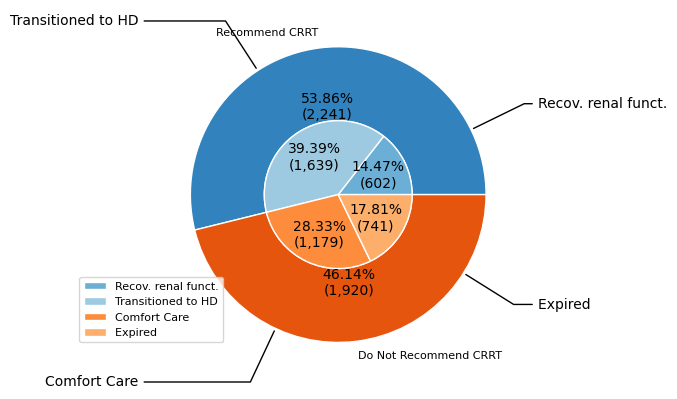

In [7]:
import numpy as np
size = 0.5
fig, ax = plt.subplots()

# ensure correct order
counts = granular_outcome.value_counts()[['Recov. renal funct.', 'Transitioned to HD', 'Comfort Care', 'Expired ']]
bin_counts = binary_outcome.value_counts()
cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

bin_outcomes = ["Recommend CRRT", "Do Not Recommend CRRT"]
outerwedges, outertexts, outerautotexts = ax.pie(
    bin_counts,
    radius=1,
    autopct=lambda p : '{:.2f}%\n({:,.0f})'.format(p,p * sum(bin_counts)/100),
    labels=bin_outcomes,
    wedgeprops=dict(width=size, edgecolor='w'),
    colors=outer_colors,
)

innerwedges, innertexts, innerautotexts = ax.pie(
    counts,
    # autopct="%1.1f%%",
    # labels=counts.index,
    radius=1-size,
    # labeldistance=0.9,
    autopct=lambda p : '{:.2f}%\n({:,.0f})'.format(p,p * sum(counts)/100),
    wedgeprops=dict(width=size, edgecolor='w'),
    colors=inner_colors,
)

# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
# kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
for i, p in enumerate(innerwedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(counts.index[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y), horizontalalignment=horizontalalignment, **kw)

ax.set(aspect='equal')
ax.legend(innerwedges, counts.index, loc=(-0.2, 0.1))
# plt.setp(innerautotexts, size=8, weight="bold")
plt.show()

# Dataset

In [4]:
preprocessed_df = load_data(args, "ucla_crrt")
ucla_control_df = load_data(args, "ucla_control")

In [5]:
ucla_control_df

,,dx_CCS_CODE_1,dx_CCS_CODE_10,dx_CCS_CODE_100,dx_CCS_CODE_101,dx_CCS_CODE_102,dx_CCS_CODE_103,dx_CCS_CODE_104,dx_CCS_CODE_105,dx_CCS_CODE_106,dx_CCS_CODE_107,...,RACE_Native Hawaiian or Other Pacific Islander,RACE_Other,RACE_Patient Refused,RACE_Unknown,RACE_White or Caucasian,ETHNICITY_Hispanic or Latino,ETHNICITY_Not Hispanic or Latino,liver_pt_indicator,heart_pt_indicator,infection_pt_indicator
IP_PATIENT_ID,Start Date,,,,,,,,,,,,,,,,,,,,,
00000064C94859EB973942C862550ABA,2020-08-10,0.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,1,0,1,1,1,1
000008E26F8F14E5099662DDB778C698,2017-09-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
00000AC44FF1345FEE4B73057620EC0F,2017-10-02,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,1
000014471A50BA85E236FC7DDA593FE6,2017-11-26,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0,1,0,0,0,0,1,1,1,1
000015CA913525E268FA991FD4AED560,2012-05-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0117DEA6B296A4BF14116169C72C9248,2013-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
02E1D0B786923B55CCD9684C0BB305D4,2009-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
045A0C05D0C3B66C71A4B8EC722A31EF,2010-05-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,1,0,0,0


In [6]:
preprocessed_df

dx_CCS_CODE_1  dx_CCS_CODE_10  \
IP_PATIENT_ID                    Start Date                                  
0005F7B7C7B389A7778C442AAD8BB325 2020-02-11            0.0             0.0   
                                 2020-03-03            0.0             0.0   
000A7F3313811793921F5292DED8952B 2020-03-01            NaN             NaN   
00410D475813633FCD90F115426AC192 2021-06-27            0.0             0.0   
005DE8D3BA075A3E439E4535E9E6B998 2015-08-20            0.0             0.0   
...                                                    ...             ...   
FFBB88418EEE2BE893542B6BA5A6471A 2016-05-29            NaN             NaN   
FFCB1F6B465D87300BDEE7AB7C271467 2020-10-25            0.0             1.0   
FFDC60CAB85E68EB394EB2CF8A8736EA 2016-07-14            1.0             0.0   
                                 2016-09-07            NaN             NaN   
FFF843AEBA183EBBF3BC5DBFFB364039 2015-07-04            NaN             NaN   

                                             dx_CCS_CODE_100  dx_CCS_CODE_101  \
IP_PATIENT_ID                    Start Date                                     
0005F7B7C7B389A7778C442AAD8BB325 2020-02-11              1.0              1.0   
                                 2020-03-03              0.0              2.0   
000A7F3313811793921F5292DED8952B 2020-03-01              NaN              NaN   
00410D475813633FCD90F115426AC192 2021-06-27              0.0              0.0   
005DE8D3BA075A3E439E4535E9E6B998 2015-08-20              0.0              0.0   
...                                                      ...              ...   
FFBB88418EEE2BE893542B6BA5A6471A 2016-05-29              NaN              NaN   
FFCB1F6B465D87300BDEE7AB7C271467 2020-10-25              0.0              0.0   
FFDC60CAB85E68EB394EB2CF8A8736EA 2016-07-14              0.0              0.0   
                                 2016-09-07              NaN              NaN   
FFF843AEBA183EBBF3BC5DBFFB364039 2015-07-04              NaN              NaN   

                                             dx_CCS_CODE_102  dx_CCS_CODE_103  \
IP_PATIENT_ID                    Start Date                                     
0005F7B7C7B389A7778C442AAD8BB325 2020-02-11              0.0              0.0   
                                 2020-03-03              0.0              0.0   
000A7F3313811793921F5292DED8952B 2020-03-01              NaN              NaN   
00410D475813633FCD90F115426AC192 2021-06-27              0.0              0.0   
005DE8D3BA075A3E439E4535E9E6B998 2015-08-20              0.0              0.0   
...                                                      ...              ...   
FFBB88418EEE2BE893542B6BA5A6471A 2016-05-29              NaN              NaN   
FFCB1F6B465D87300BDEE7AB7C271467 2020-10-25              0.0              0.0   
FFDC60CAB85E68EB394EB2CF8A8736EA 2016-07-14              0.0              2.0   
                                 2016-09-07              NaN              NaN   
FFF843AEBA183EBBF3BC5DBFFB364039 2015-07-04              NaN              NaN   

                                             dx_CCS_CODE_104  dx_CCS_CODE_105  \
IP_PATIENT_ID                    Start Date                                     
0005F7B7C7B389A7778C442AAD8BB325 2020-02-11              0.0              0.0   
                                 2020-03-03              0.0              0.0   
000A7F3313811793921F5292DED8952B 2020-03-01              NaN              NaN   
00410D475813633FCD90F115426AC192 2021-06-27              0.0              0.0   
005DE8D3BA075A3E439E4535E9E6B998 2015-08-20              0.0              0.0   
...                                                      ...              ...   
FFBB88418EEE2BE893542B6BA5A6471A 2016-05-29              NaN              NaN   
FFCB1F6B465D87300BDEE7AB7C271467 2020-10-25              0.0              0.0   
FFDC60CAB85E68EB394EB2CF8A8736EA 2016-07-14              0.0              0.0   
                               

# Patient Type

In [15]:
import upsetplot
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd
def plot_upsetplot(preprocessed_df: pd.DataFrame, cohort: str, colnames: list[str]):
    fig = plt.figure(figsize=(10, 30))
    indicator_cols = preprocessed_df[colnames].astype(bool)
    data = pd.concat([indicator_cols, preprocessed_df["recommend_crrt"]],axis=1).replace({0: "Do not recommend CRRT", 1: "Recommend CRRT"})
    myplot = upsetplot.UpSet(data.set_index(colnames), intersection_plot_elements=0, show_counts=True, show_percentages=True, element_size=50)
    myplot.add_stacked_bars(by="recommend_crrt", colors=cm.Set2, elements=10)
    myplot.plot()
    plt.title(f"{cohort} Patient Type Breakdown")
    plt.show()

In [31]:
race_cols = preprocessed_df.columns[preprocessed_df.columns.str.contains("RACE_")].to_list()
race_cols

['RACE_American Indian or Alaska Native',
 'RACE_Asian',
 'RACE_Black or African American',
 'RACE_Multiple Races',
 'RACE_Native Hawaiian or Other Pacific Islander',
 'RACE_Other',
 'RACE_Patient Refused',
 'RACE_Unknown',
 'RACE_White or Caucasian']

<Figure size 1000x3000 with 0 Axes>

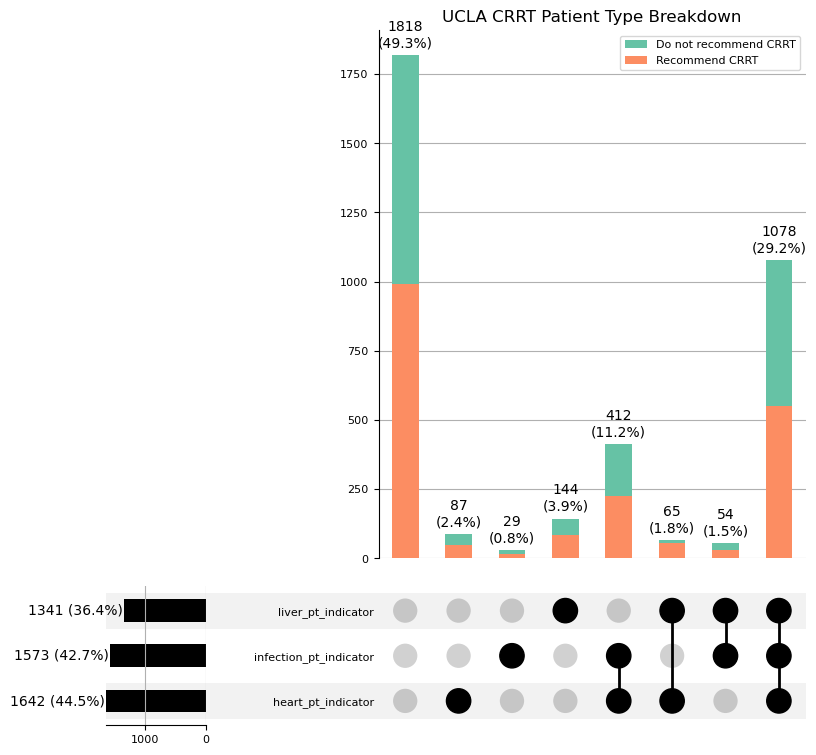

<Figure size 1000x3000 with 0 Axes>

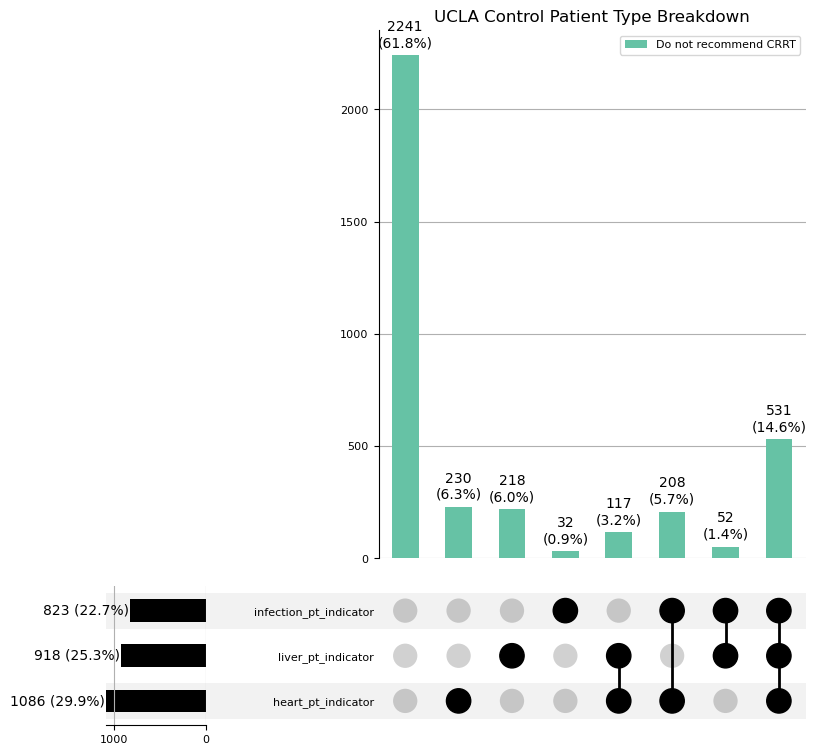

<Figure size 1000x3000 with 0 Axes>

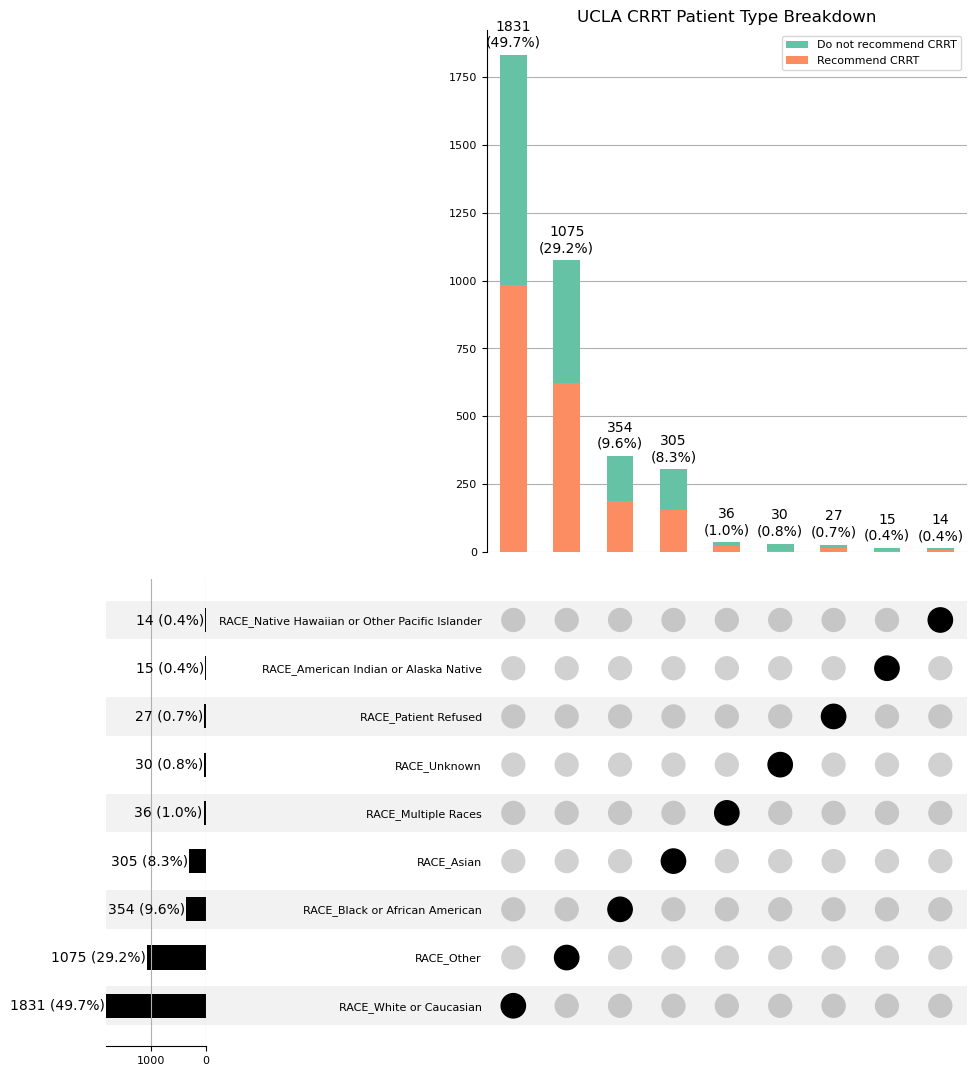

<Figure size 1000x3000 with 0 Axes>

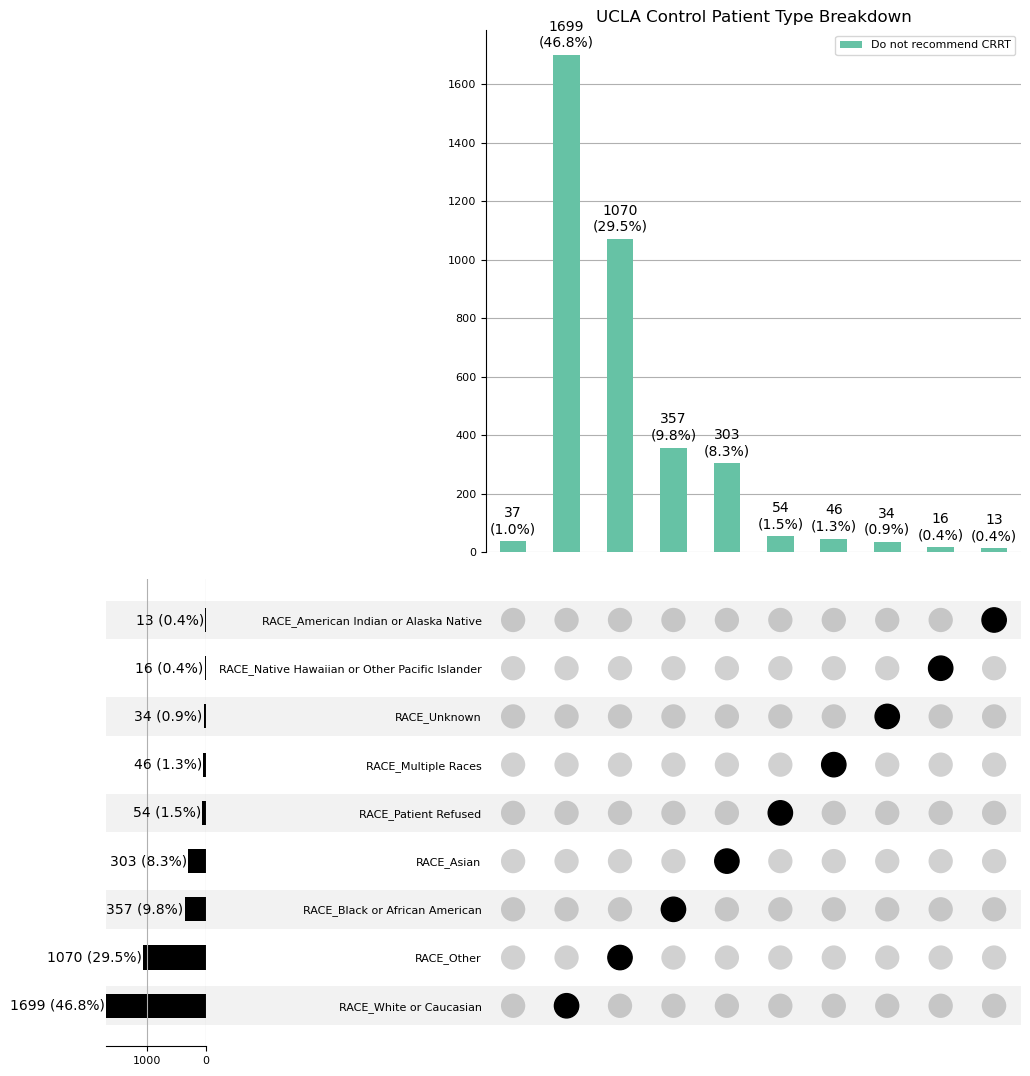

In [32]:
disease_groups =  [f"{name}_pt_indicator" for name in ["heart", "liver", "infection"]]
for columns in [disease_groups, race_cols]:
    plot_upsetplot(preprocessed_df, "UCLA CRRT", columns)
    plot_upsetplot(ucla_control_df, "UCLA Control", columns)

## Numerical Breakdown

In [15]:
myplot.total

NameError: name 'myplot' is not defined

In [ ]:
print(preprocessed_df["recommend_crrt"].value_counts())
print(preprocessed_df["recommend_crrt"].value_counts(normalize=True)*100)

1    2106
0    1791
Name: recommend_crrt, dtype: int64
1    54.04157
0    45.95843
Name: recommend_crrt, dtype: float64


In [ ]:
from IPython.display import display
for table in [myplot.totals, myplot.intersections]:
    display(pd.concat([table.rename("N"), (table/myplot.total*100).rename("%")], axis=1), )

,N,%
liver_pt_indicator,2062,52.912497
heart_pt_indicator,2060,52.861175
infection_pt_indicator,1416,36.335643


N          %
liver_pt_indicator heart_pt_indicator infection_pt_indicator                 
False              False              False                   1712  43.931229
True               False              False                     72   1.847575
False              True               False                     77   1.975879
                   False              True                      20   0.513215
True               True               False                    620  15.909674
                   False              True                      33   0.846805
False              True               True                      26   0.667180
True               True               True                    1337  34.308442

In [ ]:
df = myplot._df.set_index("recommend_crrt", append=True, drop=False)
gb = df.groupby(level=list(range(df.index.nlevels)), sort=True)
counts = gb.size()
# percents = counts / df.groupby(level=list(range(df.index.nlevels - 2)), sort=True) * 100
percents = counts / myplot.intersections * 100
pd.concat([counts.rename("N"), percents.rename("%")], axis=1)

N  \
liver_pt_indicator heart_pt_indicator infection_pt_indicator recommend_crrt               
False              False              False                  Do not recommend CRRT  782   
                                                             Recommend CRRT         930   
                                      True                   Do not recommend CRRT    7   
                                                             Recommend CRRT          13   
                   True               False                  Do not recommend CRRT   38   
                                                             Recommend CRRT          39   
                                      True                   Do not recommend CRRT   12   
                                                             Recommend CRRT          14   
True               False              False                  Do not recommend CRRT   39   
                                                             Recommend CRRT          33   
                                      True                   Do not recommend CRRT   20   
                                                             Recommend CRRT          13   
                   True               False                  Do not recommend CRRT  308   
                                                             Recommend CRRT         312   
                                      True                   Do not recommend CRRT  585   
                                                             Recommend CRRT         752   

                                                                                            %  
liver_pt_indicator heart_pt_indicator infection_pt_indicator recommend_crrt                    
False              False              False                  Do not recommend CRRT  45.677570  
                                                             Recommend CRRT         54.322430  
                                      True                   Do not recommend CRRT  35.000000  
                                                             Recommend CRRT         65.000000  
                   True               False                  Do not recommend CRRT  49.350649  
                                                             Recommend CRRT         50.649351  
                                      True                   Do not recommend CRRT  46.153846  
                                                             Recommend CRRT         53.846154  
True               False              False                  Do not recommend CRRT  54.166667  
                                                             Recommend CRRT         45.833333  
                                      True                   Do not recommend CRRT  60.606061  
                                                             Recommend CRRT         39.393939  
                   True               False                  Do not recommend CRRT  49.677419  
                                                             Recommend CRRT         50.322581  
                                      True                   Do not recommend CRRT  43.754675  
                                                             Recommend CRRT         56.245325

# MISSING Data

In [3]:
tmp_df = preprocessed_df.drop(preprocessed_df.columns[preprocessed_df.columns.str.contains("^Unnamed")], axis=1)
def print_missing_info(filter = None):
    if filter is not None:
        total_notmissing = sum(~tmp_df[filter].isna().any(axis=1))
    else:
        total_notmissing = sum(~tmp_df.isna().any(axis=1))
    print(f"Number of patients not missing any data: {total_notmissing}, ({total_notmissing/tmp_df.shape[0] * 100}%)")
print("All")
print_missing_info()

All
Number of patients not missing any data: 0, (0.0%)


In [15]:
(tmp_df.drop(["infection_pt_indicator", "liver_pt_indicator", "heart_pt_indicator", "recommend_crrt", "CRRT Year"], axis=1).isna().mean() * 100).sort_values()

# column_mask = pd.read_pickle(join("/home/davina/Private/repos/CRRT", "local_data","data_transform.pkl")).__self__.named_steps[
#                 "feature-selection"
#             ].get_support()
column_mask = pd.read_pickle(join("/home/davina/Private/repos/CRRT", "selected_columns.pkl"))

# tmp_df[tmp_df.drop("recommend_crrt",axis=1).columns[column_mask]].drop(["infection_pt_indicator", "liver_pt_indicator", "heart_pt_indicator"], axis=1)

amount_missing = tmp_df.drop("recommend_crrt",axis=1)[column_mask].isna().mean().sort_values()
amount_missing.name = "% Missing"
amount_missing.index.name = "Variables"
(amount_missing*100).to_csv(join("/home/davina/Private/repos/CRRT", "variables_and_amount_missing.csv"))
amount_missing

Variables
CRRT Year                                 0.000000
PHARM_SUBCLASS_Chlorine Antiseptics       0.062754
PHARM_SUBCLASS_Cobalamins                 0.062754
PHARM_SUBCLASS_Coumarin Anticoagulants    0.062754
PHARM_SUBCLASS_Diagnostic Drugs           0.062754
                                            ...   
HTLV I DNA_len                            0.999730
17-OH-PREGNENOLONE_max                    1.000000
IONIZED CALCIUM(NON-PATIENT)_max          1.000000
LACTATE/PYRUVATE RATIO_mean               1.000000
17-OH-PREGNENOLONE_min                    1.000000
Name: % Missing, Length: 2045, dtype: float64

In [ ]:
tmp_df[tmp_df.columns[tmp_df.columns.str.contains("_na")]].mean()

dx_CCS_CODE_na    0.824272
pr_CCS_CODE_na    0.134976
CPT_SECTION_na    6.061033
dtype: float64

In [ ]:
import pandas as pd
percent_missing_per_feature = tmp_df.isna().sum() / tmp_df.shape[0] * 100
percents = pd.Series([10, 25, 50], name=">= Percent Missing")
counts = pd.Series([(percent_missing_per_feature >= (p/100)).sum() for p in percents])

pd.DataFrame(counts, index=percents)

,0
>= Percent Missing,
10,NaN
25,NaN
50,NaN
